In [1]:
"""
以下代码参考了https://www.kaggle.com/husainsb/lendingclub-issued-loans 的若干案例
向原作者致谢！
"""
#工作包准备
import numpy as np
np.seterr(all='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
sns.set_style("whitegrid",{'font.sans-serif':['simhei','Arial']})


#一个用来绘制分割线的函数
def Separate(s):
    print()
    print('*'*40)
    print(s)
    print('*'*40)

Separate("工作包准备")


****************************************
工作包准备
****************************************


In [2]:
#观察数据概况
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#开发阶段，为了节省数据加载时间，可以只读取部分数据，用于开发测
#试用但是读取数据量的多少，会影响到数据清洗代码的执行，请小心处理
#调试通过后，读取所有数据
#dfsample = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip', low_memory=True,nrows=10000)
#dfsample.to_csv("LendingClub10k.csv",index=False)

#原始数据文件accepted_2007_to_2017Q3.csv.gz超过200M，解压后内存占用1.8G+，
#LendingClub10k.csv是从中随机抽取的10k条记录，请根据实际情况选择一下两条语句中的一条
#dforigin = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', low_memory=True, compression='gzip')
dforigin = pd.read_csv('LendingClub10k.csv',sep=',')

Separate('Original data shape')
dforigin.info()
print(dforigin.shape)


****************************************
Original data shape
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(113), int64(1), object(37)
memory usage: 11.5+ MB
(10000, 151)


C:\Users\houfang\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Separate('显示 loan_status字段:')
print(dforigin['loan_status'].value_counts())
df = dforigin.loc[dforigin['loan_status'].\
                  isin(['Fully Paid', 'Charged Off'])].copy(deep=True)

Separate('显示 loan_status 是 Fully_paid 和 Charged off取值的记录数:')
print(df['loan_status'].value_counts())
print(df.shape)

Separate("显示df中正常还款和违约样本比例：")
print(df['loan_status'].value_counts() / df.shape[0])
df['loan_status'] = df['loan_status'].\
                   apply(lambda s: np.float(s == 'Charged Off'))

Separate('Fully paid 取值为0； Charged off 取值为 1 ')
print(df['loan_status'].value_counts())
df.rename(columns={'loan_status':'charged_off'}, inplace=True)


****************************************
显示 loan_status字段:
****************************************
Current                                                4797
Fully Paid                                             3891
Charged Off                                            1061
Late (31-120 days)                                      149
In Grace Period                                          56
Late (16-30 days)                                        28
Does not meet the credit policy. Status:Fully Paid       12
Does not meet the credit policy. Status:Charged Off       5
Name: loan_status, dtype: int64

****************************************
显示 loan_status 是 Fully_paid 和 Charged off取值的记录数:
****************************************
Fully Paid     3891
Charged Off    1061
Name: loan_status, dtype: int64
(4952, 151)

****************************************
显示df中正常还款和违约样本比例：
****************************************
Fully Paid     0.785743
Charged Off    0.214257
Name: loan_status, dty

In [4]:
#丢弃只有唯一值的列
Separate('丢弃只有唯一值的列')
drop_list = []
for col in df.columns:
    if df[col].nunique() == 1:
        drop_list.append(col)

print(drop_list)
print(df.shape)

df.drop(labels=drop_list, axis=1, inplace=True)
df.shape


****************************************
丢弃只有唯一值的列
****************************************
['pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'hardship_flag', 'hardship_type', 'hardship_status', 'deferral_term', 'hardship_length']
(4952, 151)


(4952, 140)

In [5]:
#丢弃那些大量缺失值的列
Separate('丢弃那些缺失值超过98%的列')
drop_list = []
for col in df.columns:
    if df[col].notnull().sum() / df.shape[0] < 0.02:
        drop_list.append(col)

print(drop_list)
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape


****************************************
丢弃那些缺失值超过98%的列
****************************************
['member_id', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_mths_since_last_major_derog', 'hardship_reason', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']


(4952, 108)

In [6]:
#丢弃那些明显与目标无关的列
Separate('丢弃那些通过观察判断与研究对象无关的属性列')
df.drop(labels=['id', 'emp_title', 'title', 'last_credit_pull_d',
                'earliest_cr_line'], axis=1, inplace=True)

df.drop(labels=['collection_recovery_fee', 'debt_settlement_flag', 
                'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 
                 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
                'total_rec_late_fee', 'total_rec_prncp'], axis=1, inplace=True)
print(df.shape)


****************************************
丢弃那些通过观察判断与研究对象无关的属性列
****************************************
(4952, 93)



****************************************
绘图观察贷款目的与违约之间的关系,违约值为1
****************************************


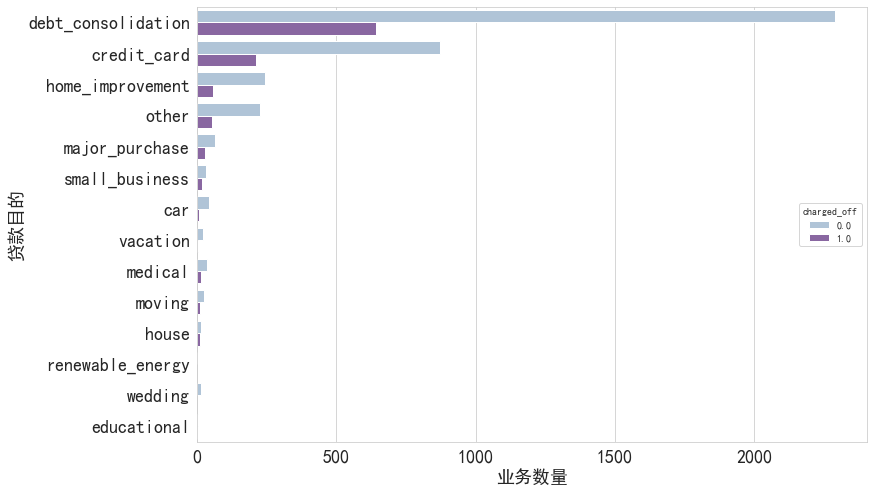

In [7]:
#考察贷款目的与违约之间的关系
Separate('绘图观察贷款目的与违约之间的关系,违约值为1')
plt.figure(figsize=(12,8))
sns.countplot(y='purpose', hue='charged_off', data=df,
              orient='h',palette = 'BuPu')
plt.yticks(size=18)
plt.ylabel('贷款目的',fontdict={'size':18})
plt.xticks(size=18)
plt.xlabel('业务数量',fontdict={'size':18})
plt.savefig("ch18_lc01.jpg",dpi=300,bbox_inches="tight")
plt.show()


****************************************
绘图观察信用分级与违约之间的关系,违约值为1
****************************************


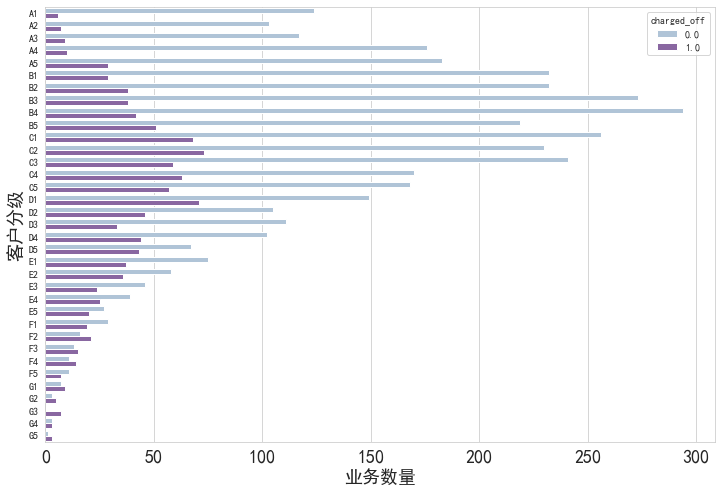

In [8]:
#考察信用分级与违约之间的关系
Separate('绘图观察信用分级与违约之间的关系,违约值为1')
plt.figure(figsize=(12,8))
sns.countplot(y='sub_grade', hue='charged_off', data=df,
              order=sorted(df['sub_grade'].value_counts().index),
              orient='h',palette = 'BuPu')
plt.ylabel('客户分级',fontdict={'size':18})
plt.xticks(size=18)
plt.xlabel('业务数量',fontdict={'size':18})
plt.savefig("ch18_lc02.jpg",dpi=300,bbox_inches="tight")
plt.show()


****************************************
绘图观察贷款期限与违约之间的关系,违约值为1
****************************************


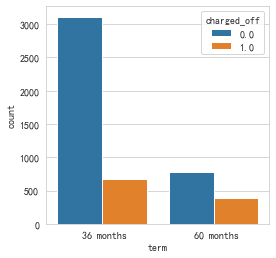

In [9]:
#考察贷款期限与违约之间的关系
Separate('绘图观察贷款期限与违约之间的关系,违约值为1')
plt.figure(figsize=(4,4))
sns.countplot(x='term', hue='charged_off', data=df)
plt.savefig("ch18_lc03.jpg",dpi=300,bbox_inches="tight")
plt.show()


****************************************
绘图观察FICO评分与违约之间的关系,违约值为1
****************************************


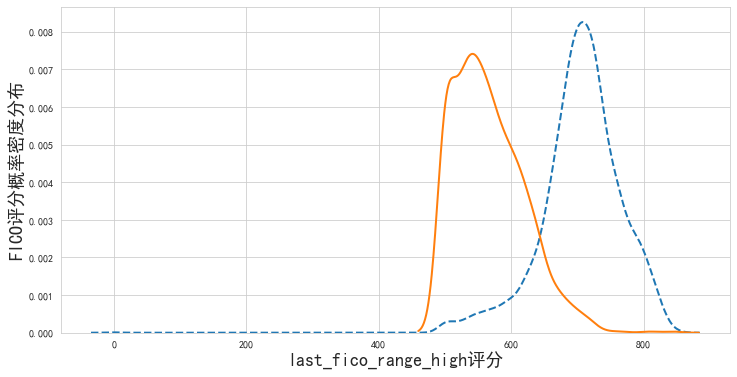

In [10]:
#考察FICO评分与违约之间的关系
Separate('绘图观察FICO评分与违约之间的关系,违约值为1')
plt.figure(figsize=(12,6))
sns.kdeplot(df['last_fico_range_high'].loc[df['charged_off']==0], 
            gridsize=500, label='charged_off = 0',linewidth=2,linestyle='--')
sns.kdeplot(df['last_fico_range_high'].loc[df['charged_off']==1], 
            gridsize=500, label='charged_off = 1',linewidth=2,linestyle='-')
plt.xlabel('last_fico_range_high评分',fontdict={'size':18})
plt.ylabel('FICO评分概率密度分布',fontdict={'size':18})
plt.savefig("ch18_lc04.jpg",dpi=300,bbox_inches="tight")
plt.show()


****************************************
多属性相关性分析
****************************************


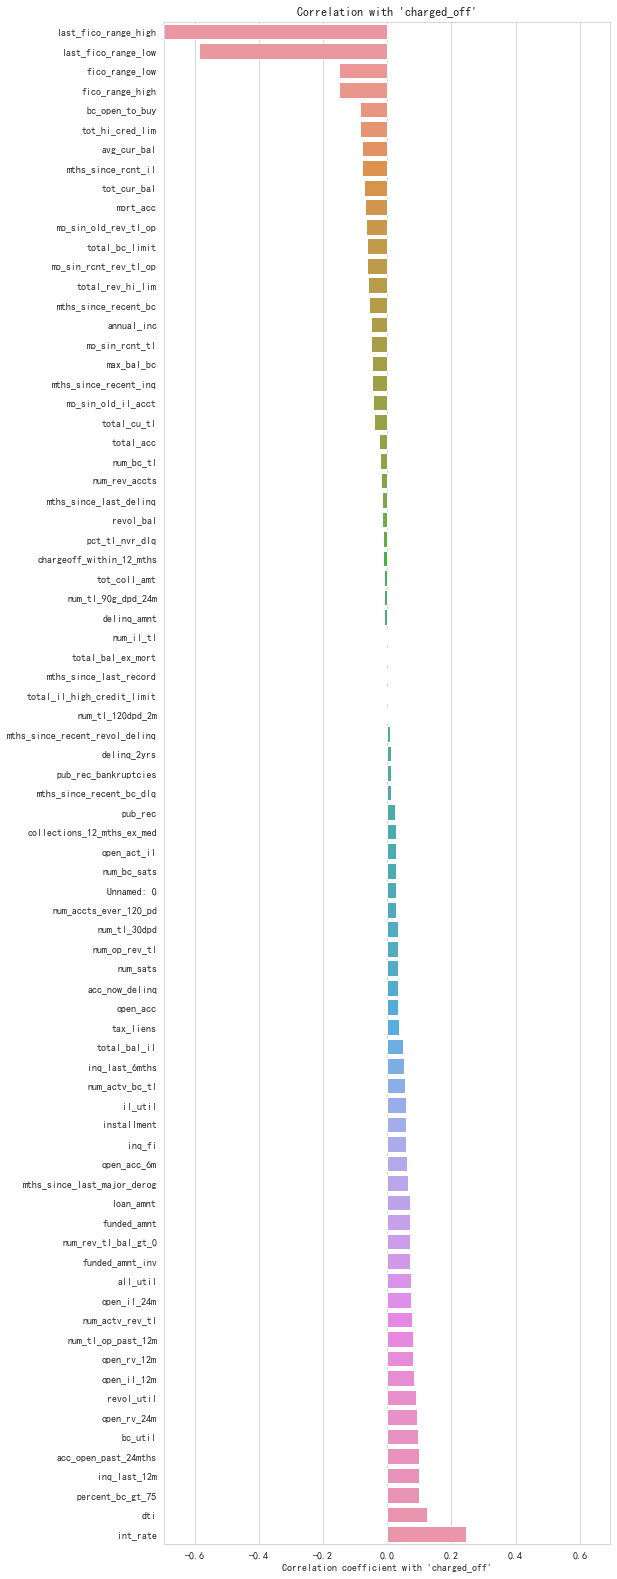

In [11]:
#多属性相关性分析
Separate('多属性相关性分析')
corr_charged_off = df.corr()['charged_off']
corr_charged_off.drop(labels='charged_off', inplace=True)
corr_charged_off = corr_charged_off.sort_values()
plt.figure(figsize=(8,28))
sns.barplot(y=corr_charged_off.index, x=corr_charged_off.values, orient='h')
plt.title("Correlation with 'charged_off'")
plt.xlabel("Correlation coefficient with 'charged_off'")
xmax = np.abs(corr_charged_off).max()
plt.xlim([-xmax, xmax])
plt.savefig("ch18_lc05.jpg",dpi=300,bbox_inches="tight")
plt.show()

In [12]:
#非数值型数据转换为数值型
Separate('非数值型数据转换为数值型')
text_cols = []
for col in df.columns:
    if df[col].dtype == np.object:
        text_cols.append(col)
print(text_cols)


****************************************
非数值型数据转换为数值型
****************************************
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'desc', 'purpose', 'zip_code', 'addr_state', 'initial_list_status', 'application_type', 'disbursement_method']


In [13]:
#转换term列
Separate('转换term列')
df['term'] = df['term'].apply(lambda s:np.float(s[1:3])) 
# There's an extra space in the data for some reason
print(df['term'].value_counts())


****************************************
转换term列
****************************************
36.0    3784
60.0    1168
Name: term, dtype: int64


In [14]:
#转换sub_grade列
Separate('转换sub_grade列为数值，并统计各取值的客户数量')
grade_dict = {'A':0.0, 'B':1.0, 'C':2.0, 'D':3.0, 'E':4.0, 'F':5.0, 'G':6.0}

def grade_to_float(s):
    return 5 * grade_dict[s[0]] + np.float(s[1]) - 1

df['sub_grade'] = df['sub_grade'].apply(lambda s: grade_to_float(s))

print(df['sub_grade'].value_counts())

#sub_grade属性中包含了grade属性的信息，后者可以删去
df.drop(labels=['grade'], axis=1, inplace=True)


****************************************
转换sub_grade列为数值，并统计各取值的客户数量
****************************************
8.0     336
10.0    324
7.0     311
11.0    303
12.0    300
9.0     270
6.0     270
5.0     261
13.0    233
14.0    225
15.0    220
4.0     212
3.0     186
16.0    151
18.0    146
17.0    144
0.0     130
2.0     126
20.0    112
19.0    110
1.0     110
21.0     94
22.0     70
23.0     64
25.0     48
24.0     47
26.0     37
27.0     28
28.0     25
29.0     18
30.0     16
31.0      8
32.0      7
33.0      6
34.0      4
Name: sub_grade, dtype: int64


In [15]:
#转换emp_length列
Separate('转换emp_length列，统计各取值用户数量')

def emp_conv(s):
    try:
        if pd.isnull(s):
            return s
        elif s[0] == '<':
            return 0.0
        elif s[:2] == '10':
            return 10.0
        else:
            return np.float(s[0])
    except TypeError:
        return np.float64(s)

df['emp_length'] = df['emp_length'].apply(lambda s: emp_conv(s))
print(df['emp_length'].value_counts())


****************************************
转换emp_length列，统计各取值用户数量
****************************************
10.0    1601
2.0      459
0.0      393
3.0      370
5.0      327
4.0      321
1.0      304
6.0      257
7.0      247
8.0      223
9.0      194
Name: emp_length, dtype: int64


In [16]:
#转换home_ownership列
Separate('转换home_ownership列，统计各取值用户数量')
Hownship_dict = {'OWN':0.0, 'MORTGAGE':1.0, 'RENT':2.0, 
                 'OTHER':3.0, 'ANY':4.0, 'NONE':5.0 }
def Hownshop_to_float(s):
    return Hownship_dict[s]
df['home_ownership'] = df['home_ownership'].apply(lambda s: Hownshop_to_float(s))
print(df['home_ownership'].value_counts())


****************************************
转换home_ownership列，统计各取值用户数量
****************************************
1.0    2423
2.0    2021
0.0     506
4.0       1
5.0       1
Name: home_ownership, dtype: int64


In [17]:
#转换verification_status列
Separate('转换verification_status列,统计各取值用户数量')

Vstatus_dict = {'Source Verified':0.0, 'Verified':1.0, 'Not Verified':2.0}
def Vstatus_dict_to_float(s):
    return Vstatus_dict[s]
df['verification_status'] = df['verification_status'].\
               apply(lambda s: Vstatus_dict_to_float(s))
print(df['verification_status'].value_counts())


****************************************
转换verification_status列,统计各取值用户数量
****************************************
0.0    1762
1.0    1676
2.0    1514
Name: verification_status, dtype: int64


In [18]:
#转换purpose列
Separate('转换purpose列,统计各取值用户数量')

Purpose_dict = {'debt_consolidation':0.0, 'credit_card':1.0, 'home_improvement':2.0,
                'other':3.0,'major_purchase':4.0, 'small_business':5.0, 'car':6.0,
                'medical':7.0, 'moving':8.0,'vacation':9.0, 'house':10.0, 
                'wedding':11.0, 'renewable_energy':12.0, 'educational':13.0 }
def Purpose_dict_to_float(s):
    return Purpose_dict[s]
df['purpose'] = df['purpose'].apply(lambda s: Purpose_dict_to_float(s))
print(df['purpose'].value_counts())


****************************************
转换purpose列,统计各取值用户数量
****************************************
0.0     2930
1.0     1083
2.0      303
3.0      280
4.0       94
6.0       53
5.0       51
7.0       49
8.0       35
9.0       27
10.0      26
11.0      13
13.0       6
12.0       2
Name: purpose, dtype: int64


In [19]:
#处理zip_code和addr_state
Separate('处理zip_code和addr_state ')

df['zip_code'] = df['zip_code'].apply(lambda s:np.float(s[:3]))
df.drop(labels=['addr_state'], axis=1, inplace=True)


****************************************
处理zip_code和addr_state 
****************************************


In [20]:
#转换 initial_list_status列
Separate('转换 initial_list_status列,统计各取值用户数量')

ILS_dict = {'f':0.0, 'w':1.0}
def ILS_dict_to_float(s):
    return ILS_dict[s]
df['initial_list_status'] = df['initial_list_status'].apply(lambda s: ILS_dict_to_float(s))
print(df['initial_list_status'].value_counts())


****************************************
转换 initial_list_status列,统计各取值用户数量
****************************************
1.0    2482
0.0    2470
Name: initial_list_status, dtype: int64


In [21]:
#转换application_type列
Separate('转换application_type列,统计各取值用户数量')

AppType_dict = {'Individual':0.0, 'Joint App':1.0}
def AppType_dict_to_float(s):
    return AppType_dict[s]
df['application_type'] = df['application_type'].apply(lambda s: AppType_dict_to_float(s))
print(df['application_type'].value_counts())


****************************************
转换application_type列,统计各取值用户数量
****************************************
0.0    4926
1.0      26
Name: application_type, dtype: int64


In [22]:
#转换disbursement_method列
Separate('转换disbursement_method列,统计各取值用户数量')

DisbMethod_dict = {'Cash':0.0, 'DirectPay':1.0}
def DisbMethod_dict_to_float(s):
    return DisbMethod_dict[s]
df['disbursement_method'] = df['disbursement_method'].apply(lambda s: DisbMethod_dict_to_float(s))
print(df['disbursement_method'].value_counts())


****************************************
转换disbursement_method列,统计各取值用户数量
****************************************
0.0    4946
1.0       6
Name: disbursement_method, dtype: int64


In [23]:
#Some comments in this column, impossible to convert to numeric
df.drop(labels=['desc'], axis=1, inplace=True)
df.drop(labels=['issue_d'], axis=1, inplace=True)
df.shape

(4952, 89)

In [24]:
Separate('拆分训练集与测试集')
X = df.drop(labels=['charged_off'], axis=1) # Features
y = df['charged_off'] # Target variable

from sklearn.model_selection import train_test_split
random_state = 12 # I chose this randomly, just to make the results fixed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
pd.DataFrame((X_train.notnull().sum() / X_train.shape[0]).sort_values(), columns=['Fraction not null'])

from sklearn.impute import SimpleImputer
from numpy import nan as NA
imputer =SimpleImputer(missing_values=NA, strategy = "mean").fit(X_train)

X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

print("df.shape:",df.shape)
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

#定义一个性能评价函数my_eval,用于对算法预测结果进行评价
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score,roc_auc_score)
import datetime

def my_eval(y_test, y_pred):
    print('Confusion matrix')
    print(confusion_matrix(y_test, y_pred),'\n')
    print('Accuracy = ',accuracy_score(y_test, y_pred))
    print('Area under the curve:%f'%(metrics.roc_auc_score(y_test,y_pred)))


****************************************
拆分训练集与测试集
****************************************
df.shape: (4952, 89)
X_train: (4456, 88)
y_train: (4456,)
X_test: (496, 88)
y_test: (496,)


In [25]:
#逻辑回归模型
Separate('LR逻辑回归模型')
from sklearn.linear_model import LogisticRegression

lrmodel=LogisticRegression(solver='liblinear')   #初始化

start=datetime.datetime.now()
lrmodel.fit(X_train,y_train)   #fit训练模型参数
end=datetime.datetime.now()

y_lrpred=lrmodel.predict(X_test) 

my_eval(y_test, y_lrpred)  
print('Runtime =',end-start) 


****************************************
LR逻辑回归模型
****************************************
Confusion matrix
[[379  20]
 [ 24  73]] 

Accuracy =  0.9112903225806451
Area under the curve:0.851226
Runtime = 0:00:00.120261


In [26]:
#随机森林模型
Separate('随机森林模型')
from sklearn.ensemble import RandomForestClassifier

rfmodel=RandomForestClassifier()

start=datetime.datetime.now()
rfmodel.fit(X_train, y_train)
end=datetime.datetime.now()

y__rfpred=rfmodel.predict(X_test)

my_eval(y_test, y__rfpred)  
print('Runtime =',end-start)


****************************************
随机森林模型
****************************************
Confusion matrix
[[379  20]
 [ 17  80]] 

Accuracy =  0.9254032258064516
Area under the curve:0.887308
Runtime = 0:00:01.027041


In [27]:
#SGDClassifier模型
Separate('SGDClassifier:SGDClassifier是一系列采用了梯度下降来求解参数的算法的集合，例如（SVM, logistic regression)等')
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.metrics import roc_auc_score

param_grid = [{'loss': ['hinge'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'class_weight': [None, 'balanced'],
               'warm_start': [True]},
              {'loss': ['log'],
               'penalty': ['l2', 'l1'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'warm_start': [True]}]
grid = GridSearchCV(estimator=SGDClassifier(), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), 
                    n_jobs=1, pre_dispatch=1, verbose=1, return_train_score=True)

start=datetime.datetime.now()
grid.fit(X_train, y_train)
end=datetime.datetime.now()

y_SGDCpred = grid.predict(X_test)

my_eval(y_test,y_SGDCpred)  
print('Runtime =',end-start)


****************************************
SGDClassifier:SGDClassifier是一系列采用了梯度下降来求解参数的算法的集合，例如（SVM, logistic regression)等
****************************************
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Confusion matrix
[[364  35]
 [  8  89]] 

Accuracy =  0.9133064516129032
Area under the curve:0.914903
Runtime = 0:00:06.971405


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    6.9s finished


In [29]:
#使用训练好的三种模型进行预测
#从x_test中抽取一条记录，作为模拟的新输入数据
new_input=X_test.iloc[10].values.reshape(1,-1)
print("new_input=",new_input)
#使用=逻辑回归模型对该数据进行预测
print("逻辑回归预测prediction=",lrmodel.predict(new_input))
#使用随机森林模型对该数据进行预测
print("随机森林预测 prediction=",rfmodel.predict(new_input))
#使用SGDClassifier模型对该数据进行预测
print("SGDC模型预测 prediction=",grid.predict(new_input))

new_input= [[ 7.02685429e-01 -9.70306942e-01 -9.69808627e-01 -9.67542536e-01
  -5.55575134e-01 -3.05312000e-01 -9.16937915e-01 -6.26216725e-01
  -1.39797268e+00  1.06462319e+00 -4.88153343e-01  1.29874998e+00
   1.62424887e+00 -1.41394449e+00 -1.25713526e+00 -3.68785492e-01
   1.64165254e-01  1.64165254e-01 -7.51923136e-01 -4.76662859e-16
   0.00000000e+00 -8.36914012e-01 -3.76050831e-01 -3.17392138e-01
   1.78482073e+00 -1.50535543e+00 -9.95521697e-01 -5.05491586e-01
  -1.93813706e-01 -1.13466750e-01  0.00000000e+00 -7.66098851e-02
  -6.18845003e-02 -2.21433268e-17  2.00777131e-16  3.56903454e-16
  -3.36382144e-16  0.00000000e+00  5.11848647e-16  0.00000000e+00
   4.02060571e-16  0.00000000e+00  0.00000000e+00  3.35138844e-16
   4.14512296e-16  7.37376640e-16  1.23365793e-16  0.00000000e+00
   0.00000000e+00  3.45986702e-16 -1.51769471e+00 -1.17032296e-16
  -6.51736943e-01  1.31527818e+00 -7.58427226e-02 -2.60544539e-02
   2.93560669e-16 -3.24102028e-16  1.15627606e-16  0.00000000e+00